In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

In [2]:
import os
import sys

sys.path.append('../model')

import config
from game import *
from tileset import *

In [3]:
from main import create_game

game = create_game(config.STARCRAFT_ROOT)

In [4]:
tiles = game.tiles(Tileset.JUNGLE)
tile_megagroups = { x.tile_group.megagroup for x in tiles }
tile_megagroups

{0,
 1,
 2,
 3,
 4,
 5,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 32,
 33,
 34,
 35}

In [5]:
len(tile_megagroups)

27

In [6]:
{ tile_megagroup: len([x for x in tiles if x.tile_group.megagroup == tile_megagroup and not x.is_empty]) for tile_megagroup in tile_megagroups }

{0: 21,
 1: 1790,
 2: 28,
 3: 28,
 4: 28,
 5: 12,
 8: 24,
 9: 24,
 10: 24,
 11: 24,
 12: 24,
 13: 24,
 15: 24,
 16: 10,
 17: 10,
 22: 240,
 23: 144,
 24: 144,
 25: 56,
 26: 56,
 28: 84,
 29: 112,
 30: 112,
 32: 288,
 33: 288,
 34: 748,
 35: 940}

In [7]:
from collections import defaultdict

edges = defaultdict(lambda: set())

for tile in tiles:
    group = tile.tile_group
    if not group.is_doodad:
        edges[group.megagroup] |= {group.left_edge, group.right_edge, group.top_edge, group.bottom_edge}
        
edges

defaultdict(<function __main__.<lambda>()>,
            {0: {0},
             2: {1},
             3: {4},
             5: {5},
             8: {8},
             15: {11},
             9: {12},
             11: {6},
             16: {16},
             10: {9},
             12: {7},
             13: {13},
             17: {17},
             4: {15},
             34: {1, 4, 30, 31, 32, 33, 49, 50, 51, 52, 53, 54, 55, 56},
             35: {1,
              5,
              30,
              31,
              34,
              35,
              36,
              37,
              49,
              50,
              51,
              52,
              53,
              54,
              55,
              56},
             23: {1, 8, 49, 50, 51, 52, 53, 54, 55, 56},
             24: {4, 9, 49, 50, 51, 52, 53, 54, 55, 56},
             28: {1, 11, 49, 50, 51, 52, 53, 54},
             25: {6, 8, 49, 50, 51, 52, 53, 54},
             26: {7, 9, 49, 50, 51, 52, 53, 54},
             29: {8, 12

In [8]:
primary_tiles = { next(iter(edges)) for tile_megagroup, edges in edges.items() if len(edges) == 1}
primary_tiles

{0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17}

In [9]:
edge_to_primary_tile = { next(iter(edges)): tile_megagroup for tile_megagroup, edges in edges.items() if len(edges) == 1}
edge_to_primary_tile

{0: 0,
 1: 2,
 4: 3,
 5: 5,
 8: 8,
 11: 15,
 12: 9,
 6: 11,
 16: 16,
 9: 10,
 7: 12,
 13: 13,
 17: 17,
 15: 4}

In [10]:
transitional_tiles = { tile_megagroup for tile_megagroup, edges in edges.items() if len(edges) != 1 }
transitional_tiles

{22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35}

In [11]:
primary_edges = { tile_megagroup: edges & primary_tiles for tile_megagroup, edges in edges.items()}
primary_edges

{0: {0},
 2: {1},
 3: {4},
 5: {5},
 8: {8},
 15: {11},
 9: {12},
 11: {6},
 16: {16},
 10: {9},
 12: {7},
 13: {13},
 17: {17},
 4: {15},
 34: {1, 4},
 35: {1, 5},
 23: {1, 8},
 24: {4, 9},
 28: {1, 11},
 25: {6, 8},
 26: {7, 9},
 29: {8, 12},
 30: {9, 13},
 32: {8, 16},
 33: {9, 17},
 22: {1, 15}}

In [12]:
transitions = { frozenset(edge_to_primary_tile[edge] for edge in edges): tile_megagroup for tile_megagroup, edges in primary_edges.items() if len(edges) == 2}
transitions

{frozenset({2, 3}): 34,
 frozenset({2, 5}): 35,
 frozenset({2, 8}): 23,
 frozenset({3, 10}): 24,
 frozenset({2, 15}): 28,
 frozenset({8, 11}): 25,
 frozenset({10, 12}): 26,
 frozenset({8, 9}): 29,
 frozenset({10, 13}): 30,
 frozenset({8, 16}): 32,
 frozenset({10, 17}): 33,
 frozenset({2, 4}): 22}

In [13]:
megagroup_mapping = {
    3: 2, # High Dirt: Dirt
    10: 8, # High Jungle: Jungle
    17: 16, # High Temple: Temple
    13: 9, # High Raised Jungle: Raised Jungle
    12: 11, # High Ruins: Ruins
}

In [14]:
mapped_transitions = { frozenset(megagroup_mapping.get(tile) for tile in tiles): tile for tiles, tile in transitions.items()}
mapped_transitions

{frozenset({2, None}): 34,
 frozenset({None}): 22,
 frozenset({2, 8}): 24,
 frozenset({8, 11}): 26,
 frozenset({8, 9}): 30,
 frozenset({8, 16}): 33}

In [15]:
for k, v in transitions.items():
    if k in mapped_transitions:
        megagroup_mapping[mapped_transitions[k]] = v

megagroup_mapping

{3: 2, 10: 8, 17: 16, 13: 9, 12: 11, 24: 23, 26: 25, 30: 29, 33: 32}

In [16]:
@np.vectorize
def minitile_heights(minitile):
    return minitile.height

In [17]:
terrain_tiles = (tile for tile in tiles if not tile.is_doodad)
doodad_tiles = (tile for tile in tiles if tile.is_doodad)

megagroup_first_tile = {}

groups = dict()
tile_features = dict()

for tile in terrain_tiles:
    if tile.is_empty or tile in tile_features:
        continue

    megagroup = tile.tile_group.megagroup
    
    if megagroup not in megagroup_first_tile:
        megagroup_first_tile[megagroup] = tile
    
    if tile.group_id not in groups:
        if megagroup in megagroup_mapping:
            mapped_tile_group_id = tile.group_id + megagroup_first_tile[megagroup_mapping[megagroup]].group_id - megagroup_first_tile[megagroup].group_id
            groups[tile.group_id] = groups[mapped_tile_group_id]
        else:
            groups[tile.group_id] = len(groups)

    tile_features[tile] = (groups[tile.group_id], tile.group_offset + 1, np.min(minitile_heights(tile.minitiles)))

tile_kinds = len(groups)
for tile in doodad_tiles:
    if not tile.is_empty and tile not in tile_features:
        tile_features[tile] = (tile_kinds, 0)
        tile_kinds += 1

In [18]:
tile_features

{<tileset.Tile - megagroup: 0, group 1, item 0>: (0, 1, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 1>: (0, 2, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 2>: (0, 3, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 3>: (0, 4, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 4>: (0, 5, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 5>: (0, 6, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 6>: (0, 7, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 7>: (0, 8, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 8>: (0, 9, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 9>: (0, 10, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 10>: (0, 11, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 11>: (0, 12, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 12>: (0, 13, 0.0),
 <tileset.Tile - megagroup: 2, group 2, item 0>: (1, 1, 0.0),
 <tileset.Tile - megagroup: 2, group 2, item 1>: (1, 2, 0.0),
 <tileset.Tile - megagroup: 2, group 2, item 2>: (1, 3, 0.0),
 

In [19]:
len({v[0] for k, v in tile_features.items()})

1900

In [20]:
megagroup_mappings = {
    Tileset.ASHWORLD: {
        4: 2, # High Dirt: Dirt
        5: 3, # High Lava: Lava
        7: 6, # High Shale: Shale
    },
    Tileset.JUNGLE: {
        3: 2, # High Dirt: Dirt
        10: 8, # High Jungle: Jungle
        17: 16, # High Temple: Temple
        13: 9, # High Raised Jungle: Raised Jungle
        12: 11, # High Ruins: Ruins
    },
}

def features_for(tileset):
    megagroup_mapping = megagroup_mappings[tileset]
    tiles = game.tiles(tileset)
    tile_megagroups = { x.tile_group.megagroup for x in tiles }
    
    edges = defaultdict(lambda: set())

    for tile in tiles:
        group = tile.tile_group
        if not group.is_doodad:
            edges[group.megagroup] |= {group.left_edge, group.right_edge, group.top_edge, group.bottom_edge}
            
    primary_tiles = { next(iter(edges)) for tile_megagroup, edges in edges.items() if len(edges) == 1}
    edge_to_primary_tile = { next(iter(edges)): tile_megagroup for tile_megagroup, edges in edges.items() if len(edges) == 1}
    primary_edges = { tile_megagroup: edges & primary_tiles for tile_megagroup, edges in edges.items()}
    transitions = { frozenset(edge_to_primary_tile[edge] for edge in edges): tile_megagroup for tile_megagroup, edges in primary_edges.items() if len(edges) == 2}
    mapped_transitions = { frozenset(megagroup_mapping.get(tile) for tile in tiles): tile for tiles, tile in transitions.items()}
    
    for k, v in transitions.items():
        if k in mapped_transitions:
            megagroup_mapping[mapped_transitions[k]] = v

    terrain_tiles = (tile for tile in tiles if not tile.is_doodad)
    doodad_tiles = (tile for tile in tiles if tile.is_doodad)

    megagroup_first_tile = {}

    groups = dict()
    tile_features = dict()
    
    tile_features[tiles[0]] = (0, 0, 0)

    for tile in terrain_tiles:
        if tile.is_empty or tile in tile_features:
            continue

        megagroup = tile.tile_group.megagroup

        if megagroup not in megagroup_first_tile:
            megagroup_first_tile[megagroup] = tile

        if tile.group_id not in groups:
            if megagroup in megagroup_mapping:
                mapped_tile_group_id = tile.group_id + megagroup_first_tile[megagroup_mapping[megagroup]].group_id - megagroup_first_tile[megagroup].group_id
                groups[tile.group_id] = groups[mapped_tile_group_id]
            else:
                groups[tile.group_id] = len(groups)

        tile_features[tile] = (groups[tile.group_id], tile.group_offset + 1, np.min(minitile_heights(tile.minitiles)))

    tile_kinds = len(groups)
    for tile in doodad_tiles:
        if not tile.is_empty and tile not in tile_features:
            tile_features[tile] = (tile_kinds, 0, np.min(minitile_heights(tile.minitiles)))
            tile_kinds += 1
    
    return tile_features

In [21]:
ashworld_features = features_for(Tileset.ASHWORLD)
ashworld_features

{<tileset.Tile - megagroup: 0, group 0, item 0>: (0, 0, 0),
 <tileset.Tile - megagroup: 0, group 1, item 0>: (0, 1, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 1>: (0, 2, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 2>: (0, 3, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 3>: (0, 4, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 4>: (0, 5, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 5>: (0, 6, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 6>: (0, 7, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 7>: (0, 8, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 8>: (0, 9, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 9>: (0, 10, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 10>: (0, 11, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 11>: (0, 12, 0.0),
 <tileset.Tile - megagroup: 0, group 1, item 12>: (0, 13, 0.0),
 <tileset.Tile - megagroup: 2, group 2, item 0>: (1, 1, 0.0),
 <tileset.Tile - megagroup: 2, group 2, item 1>: (1, 2, 0.0),
 <t

In [22]:
len({v[0] for k, v in ashworld_features.items()})

834

In [23]:
from main import create_game

scenarios = []
scenarios += game.process_game_scenarios()
for directory in config.MAP_DIRECTORIES:
    scenarios += game.process_scenarios(directory)

Traceback (most recent call last):
  File "../model\scenario.py", line 48, in __init__
    chunk_handler(chunk_data)
  File "../model\starcraft\scenario.py", line 48, in handle_STR
    offsets = struct.unpack_from('<%dH' % string_count, data, offset=2)
struct.error: unpack_from requires a buffer of at least 131070 bytes

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "../model\game.py", line 64, in process_chk
    return [self.scenario_buider(filename, chk_file).to_scenario()]
  File "../model\starcraft\game.py", line 59, in scenario_buider
    return starcraft.scenario.ScenarioBuilder(self, filename, chk_file)
  File "../model\scenario.py", line 52, in __init__
    raise ScenarioError('Error reading chunk "%s"' % chunk_name) from e
scenario.ScenarioError: Error reading chunk "STR"


In [24]:
ashworld_scenarios = [x for x in scenarios if x.tileset == Tileset.ASHWORLD]
len(ashworld_scenarios)

47

In [25]:
sum(x.height * x.width for x in ashworld_scenarios)

1024000

In [26]:
import pandas as pd

def scenario_data(scenarios):
    for scenario in scenarios:
        for i in range(scenario.tiles.shape[0]):
            for j in range(scenario.tiles.shape[1]):
                left_tile = scenario.tiles[i, j - 1] if j != 0 else scenario.game.tiles(scenario.tileset)[0]
                top_tile = scenario.tiles[i - 1, j] if i != 0 else scenario.game.tiles(scenario.tileset)[0]
                tile = scenario.tiles[i, j]

                yield [*ashworld_features[top_tile], *ashworld_features[left_tile], *ashworld_features[tile]]

def to_data_frame(scenarios):
    return pd.DataFrame(scenario_data(scenarios), columns = [
        'top_tile_kind', 'top_tile_variant', 'top_tile_elevation',
        'left_tile_kind', 'left_tile_variant', 'left_tile_elevation',
        'tile_kind', 'tile_variant', 'tile_elevation',
    ])

In [27]:
dataset = to_data_frame(ashworld_scenarios)
dataset.shape

(1024000, 9)

In [28]:
dataset = dataset[: 50000]
dataset.shape

(50000, 9)

In [29]:
from sklearn.preprocessing import OneHotEncoder

kind_encoder = OneHotEncoder(sparse = False, categories=[range(tile_kinds)])
variant_encoder = OneHotEncoder(sparse = False, categories=[range(17)])

def one_hot_encode(dataset, column, encoder):
    values = dataset[column].values.reshape(-1, 1)
    onehot_encoded = encoder.fit_transform(values)
    data_frame = pd.DataFrame(onehot_encoded)
    data_frame.columns = [str(column) + '_' + str(col_index) for col_index in data_frame.columns]
    return data_framea

In [30]:
import pandas as pd

x = pd.concat([
    one_hot_encode(dataset, 'top_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'top_tile_variant', variant_encoder),
    dataset.top_tile_elevation,
    one_hot_encode(dataset, 'left_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'left_tile_variant', variant_encoder),
    dataset.left_tile_elevation,
], axis=1)

y = dataset.tile_kind

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1337)

In [32]:
from sklearn.linear_model import RidgeClassifier

classifier = RidgeClassifier()
classifier.fit(x_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [33]:
print(classifier.score(x_train, y_train))
print(classifier.score(x_test, y_test))

0.93968
0.92992


In [34]:
kind_to_tile = { kind: tile for tile, (kind, variant, elevation) in ashworld_features.items() }

In [39]:
import random
import graphics

def tile_to_features(tiles, i, j):
    top_tile = tiles[i - 1, j] if i != 0 else game.tiles(Tileset.ASHWORLD)[0]
    left_tile = tiles[i, j - 1] if j != 0 else game.tiles(Tileset.ASHWORLD)[0]

    top_tile_features = ashworld_features[top_tile]
    left_tile_features = ashworld_features[left_tile]
    
    return np.array([
        *kind_encoder.fit_transform([[top_tile_features[0]]])[0],
        *variant_encoder.fit_transform([[top_tile_features[1]]])[0],
        np.min(minitile_heights(top_tile.minitiles)),
        *kind_encoder.fit_transform([[left_tile_features[0]]])[0],
        *variant_encoder.fit_transform([[left_tile_features[1]]])[0],
        np.min(minitile_heights(left_tile.minitiles)),
    ])

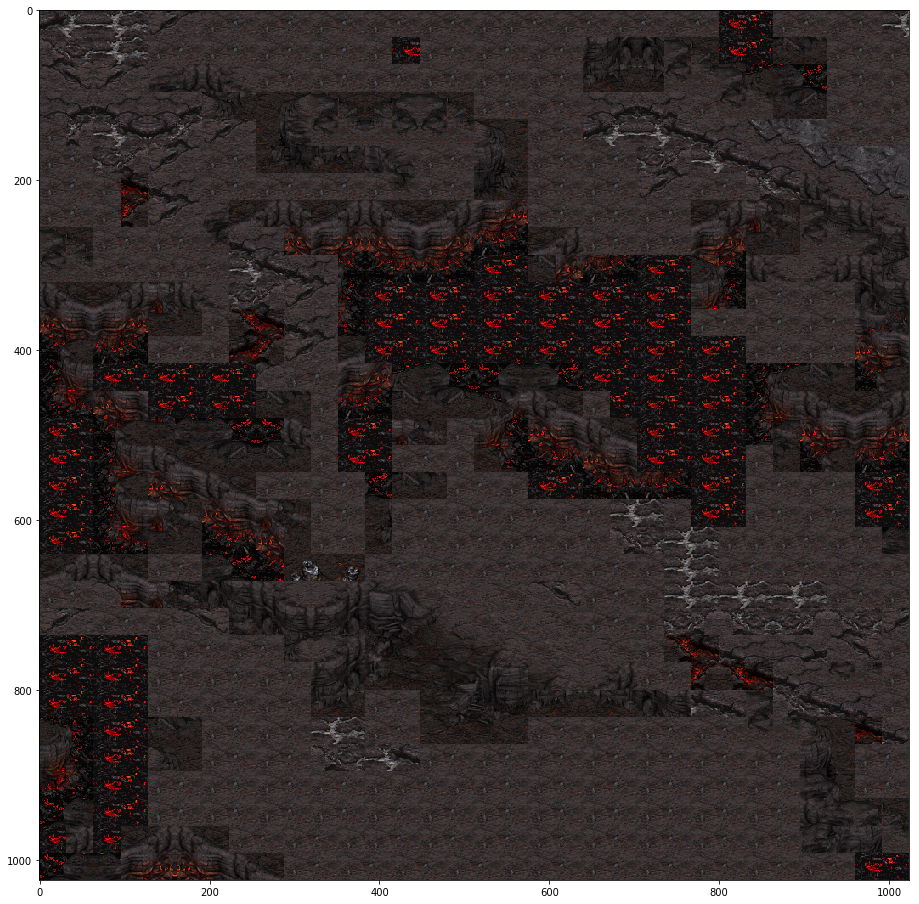

In [45]:
sampled_tiles = np.full([32, 32], game.tiles(Tileset.ASHWORLD)[0], dtype=object)

for i in range(sampled_tiles.shape[0]):
    for j in range(sampled_tiles.shape[1]):
        features = tile_to_features(sampled_tiles, i, j)
        prediction = classifier.decision_function(features.reshape(1, -1)).reshape(-1)
        p = (prediction + 1) * (prediction + 1 > 0.02)
        prediction_index = np.random.choice(len(p), p = p / p.sum())
        sampled_tiles[i, j] = kind_to_tile[classifier.classes_[prediction_index]]

plt.figure(figsize=(16, 16))
plt.imshow(graphics.tile(sampled_tiles));

In [47]:
dataset = to_data_frame(ashworld_scenarios)
dataset = dataset[: 200000]

x = pd.concat([
    one_hot_encode(dataset, 'top_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'top_tile_variant', variant_encoder),
    dataset.top_tile_elevation,
    one_hot_encode(dataset, 'left_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'left_tile_variant', variant_encoder),
    dataset.left_tile_elevation,
], axis=1)

y = dataset.tile_kind

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1337)

In [48]:
classifier2 = RidgeClassifier()
classifier2.fit(x_train, y_train)

print(classifier2.score(x_train, y_train))
print(classifier2.score(x_test, y_test))

0.9429
0.94092


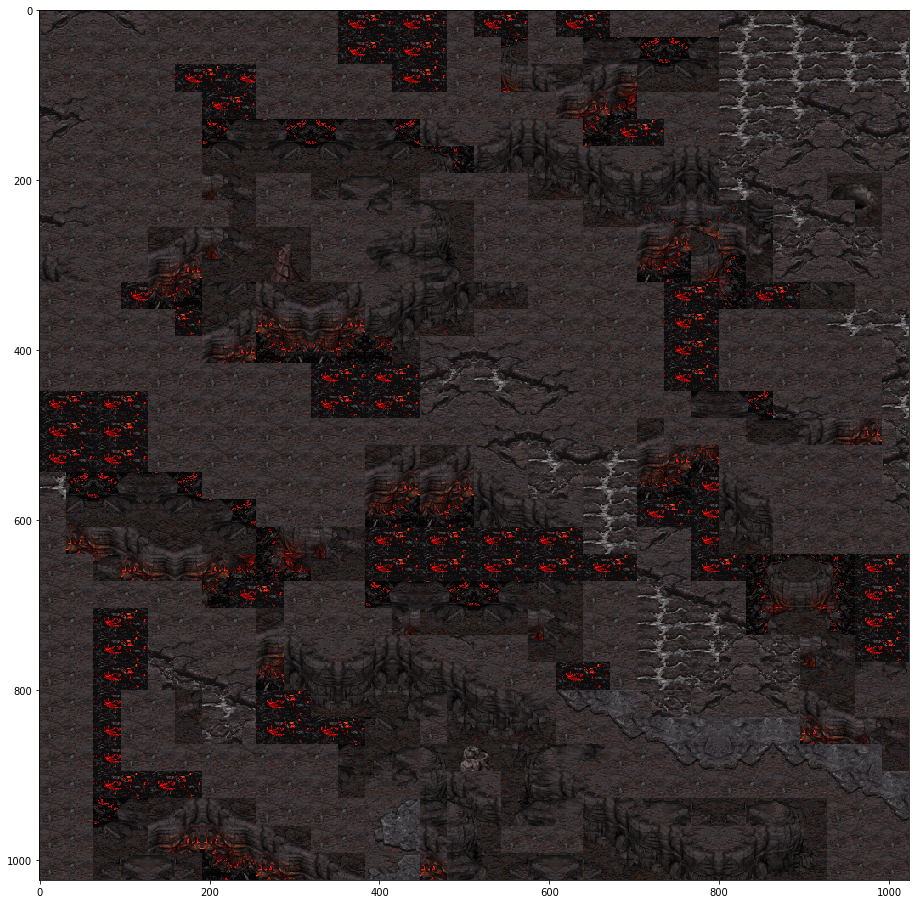

In [51]:
sampled_tiles = np.full([32, 32], game.tiles(Tileset.ASHWORLD)[0], dtype=object)

for i in range(sampled_tiles.shape[0]):
    for j in range(sampled_tiles.shape[1]):
        features = tile_to_features(sampled_tiles, i, j)
        prediction = classifier.decision_function(features.reshape(1, -1)).reshape(-1)
        p = (prediction + 1) * (prediction + 1 > 0.02)
        prediction_index = np.random.choice(len(p), p = p / p.sum())
        sampled_tiles[i, j] = kind_to_tile[classifier.classes_[prediction_index]]

plt.figure(figsize=(16, 16))
plt.imshow(graphics.tile(sampled_tiles));

In [54]:
from sklearn.preprocessing import OneHotEncoder

kind_encoder = OneHotEncoder(categories=[range(tile_kinds)])
variant_encoder = OneHotEncoder(categories=[range(17)])

def one_hot_encode(dataset, column, encoder):
    values = dataset[column].values.reshape(-1, 1)
    onehot_encoded = encoder.fit_transform(values)
    data_frame = pd.DataFrame(onehot_encoded)
    data_frame.columns = [str(column) + '_' + str(col_index) for col_index in data_frame.columns]
    return data_frame

In [56]:
x = pd.concat([
    one_hot_encode(dataset, 'top_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'top_tile_variant', variant_encoder),
    dataset.top_tile_elevation,
    one_hot_encode(dataset, 'left_tile_kind', kind_encoder),
    one_hot_encode(dataset, 'left_tile_variant', variant_encoder),
    dataset.left_tile_elevation,
], axis=1)

y = dataset.tile_kind

In [57]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1337)

In [58]:
classifier3 = RidgeClassifier()
classifier3.fit(x_train, y_train)

#print(classifier3.score(x_train, y_train))
#print(classifier3.score(x_test, y_test))

ValueError: setting an array element with a sequence.